In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
np.set_printoptions(suppress=True)
import pickle
import sys, os
import time
import libcamodocal
import matplotlib.pyplot as plt
import cv2
import quaternion
from IPython import display
from IPython.display import clear_output
import calib_utils
import calib

In [3]:
# define cb pattern
cb_pattern = (5,6)

#define checkerboard pattern size [m]
cb_size = .07

# load calib data
#calib_data = pickle.load(open("./../data/calibdata_22_03_2022_21_19_53_pick.pkl", "rb" ))
calib_data = pickle.load( open("/home/ralfi/Desktop/calibdata_29_03_2022_19_39_11.pkl", "rb" ))

# Setup Camera intrinsics
K = calib_data['intr']
print(K)

#Setup HEC Solver
setup = calib.calibrator.Setup(2)
cgi_cal = calib.calibrator.HandEyeCalibrator(setup)

[[644.39996338   0.         639.5       ]
 [  0.         644.39996338 359.5       ]
 [  0.           0.           1.        ]]


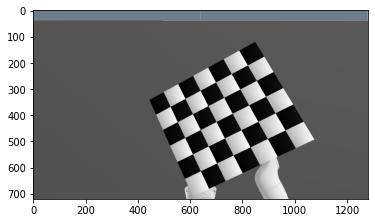

In [4]:
plt.imshow(calib_data['rgb'][0])

In [5]:
# generate pattern_3d
pattern_3d = np.zeros((np.prod(cb_pattern), 3), np.float32)
pattern_3d[:, :2] = np.indices(cb_pattern).T.reshape(-1, 2)
pattern_3d *= cb_size
pattern_3d = np.transpose(pattern_3d)

In [6]:
def pose7d2rotm(pose):
    R = quaternion.as_rotation_matrix(quaternion.from_float_array(pose[3:7]))
    rotm = np.concatenate((R, np.transpose([pose[0:3]])), axis=1)
    rotm = np.concatenate((rotm, np.array([[0,0,0,1]])), axis=0)
    return rotm

def pose7d2homTF(pose):
    R = quaternion.as_rotation_matrix(quaternion.from_float_array(pose[3:7]))
    rotm = np.concatenate((R, np.transpose([pose[0:3]])), axis=1)
    rotm = np.concatenate((rotm, np.array([[0,0,0,1]])), axis=0)
    return rotm


def draw2(rgb, cb_pattern, points_2d, ret=True):
    
    img = cv2.drawChessboardCorners(rgb, cb_pattern, points_2d, ret)
    plt.figure(figsize=(20, 20), dpi=80)
    plt.imshow(img)
    
    return img

def create_transform(R=np.eye(3),t=np.zeros((3))):
    transform = np.array([[R[0,0], R[0,1], R[0,2], t[0]],
                     [R[1,0], R[1,1], R[1,2], t[1]],
                      [R[2,0], R[2,1], R[2,2], t[2]],
                       [0,0,0,1]])

    #return transform
    return transform

def homTF2pose7d(homTF):
    
    pose7d = np.zeros(7)
    pose7d[0:3] = np.transpose(homTF[0:3, 3])

    R = homTF[0:3, 0:3]
    q_ = quaternion.from_rotation_matrix(R)
    q = quaternion.as_float_array(q_)

    pose7d[3:7] = q
    return pose7d

def review_img(i, rgb):
    
    print(f"Run {i}:")
    display.Image(rgb)
    plt.figure()

    plt.show()
    A=input('is this image good? (y)')

    if(A=='' or A == 'y'):
        print('good soup')
        soup = True
    else:
        print('bad soup')
        soup = False

    time.sleep(1)
    clear_output(wait=True)
    
    return soup

In [7]:
list_hand_pose, list_hand_pose_rotm, list_obj_pose_rotm, list_obj_pose_rotm_inv, list_hand_pose_rotm_inv = [], [], [], [], []
verbose = False
debug = False

# define criteria for subPixel computation
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

for i in range(len(calib_data['poses']) -1 ):

    rgb = calib_data['rgb'][i] #[0]
    t_obj, R_obj, hom_obj, points_2d, points_2d_, list_points_2d, corner_img = calib_utils.estimate_cam_pose_checker(rgb, K, cb_pattern, pattern_3d, np.zeros((5,1)), criteria)
    
    if(i==7):
        continue
    
    if debug:
        rev_img = draw2(rgb.copy(), cb_pattern, points_2d)
        review_img(i, rev_img)
    
    list_obj_pose_rotm.append(hom_obj)
    list_obj_pose_rotm_inv.append(np.linalg.inv(hom_obj))
    #print(hom_obj)

    if False:
    #if('poses_urx' in calib_data.keys()):
        urx_pose_inv = np.linalg.inv(urx2rotm( calib_data['poses'][i]))#[0]))
        cgi_cal.add_sample(np.linalg.inv(urx_pose_), hom_obj)
        list_hand_pose_rotm_inv.append(urx_pose_)
    else:
        urx_pose_inv = np.linalg.inv(pose7d2rotm( calib_data['poses'][i]))#[0]))
        urx_pose = pose7d2rotm( calib_data['poses'][i])
        cgi_cal.add_sample(urx_pose_inv, hom_obj)
        list_hand_pose_rotm_inv.append(urx_pose_inv)
        list_hand_pose_rotm.append(urx_pose)

TypeError: estimate_cam_pose_checker() missing 1 required positional argument: 'criteria'

In [11]:

x = lambda x:1
print(x(5)) 

1


In [8]:
####
# calculate relative pose
def relative_transform(T1,T2):
    return np.linalg.inv(T1) * T2
list_rel_hand_pose, list_rel_hand_pose_inv, list_rel_obj_pose, list_rel_obj_pose_inv = [], [], [], []
for i in range(len(list_hand_pose_rotm)-1):
    T1_ee = list_hand_pose_rotm[i]
    T2_ee = list_hand_pose_rotm[i+1]
    rel_ee = relative_transform(T1_ee, T2_ee)
    list_rel_hand_pose.append(rel_ee)
    list_rel_hand_pose_inv.append(np.linalg.inv(rel_ee))
    
    T1_cam = list_obj_pose_rotm[i]
    T2_cam = list_obj_pose_rotm[i+1]
    rel_cam = relative_transform(T1_cam, T2_cam)
    list_rel_obj_pose.append(rel_cam)
    list_rel_obj_pose_inv.append(np.linalg.inv(rel_cam))

In [9]:
lol = libcamodocal.py_camodocal_calibration(list_rel_hand_pose_inv, list_rel_obj_pose, {}, False)
print(lol)

[[ 0.239407   -0.71805718 -0.65351219 -1.76565739]
 [ 0.83065524  0.49996542 -0.24504375 -1.0115993 ]
 [ 0.50268892 -0.48417814  0.71615318  2.11195797]
 [ 0.          0.          0.          1.        ]]


In [5]:
import yaml

with open("./tfs.yaml", "r") as stream:
    try:
        data = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [12]:
#Setup HEC Solver
setup = calib.calibrator.Setup(2)
cgi_cal = calib.calibrator.HandEyeCalibrator(setup)
N = int(len(data)/2)
list_hand_pose_rotm, list_obj_pose_rotm =  [],[]
for i in range(N):
    #ee
    T1 = data[f"T1_{str(i)}"]['data']
    T1 = np.array(T1).reshape(4,4)
    #print(T1)
    list_hand_pose_rotm.append(T1)
    #cam
    T2 = data[f"T2_{str(i)}"]['data']
    T2 = np.array(T2).reshape(4,4)
    #print(T2)
    list_obj_pose_rotm.append(T2)
    cgi_cal.add_sample(T1, T2)

In [8]:
lol = libcamodocal.py_camodocal_calibration(list_hand_pose_rotm, list_obj_pose_rotm, {}, True)
print(lol)

Adding Transform #:0
L2Norm EE: 0.546562 vs Cam:0.702483
[[-0.05607666  0.23077032  0.971391    0.8750511 ]
 [ 0.68533608  0.7164143  -0.13063308 -0.45641543]
 [-0.72606464  0.65840383 -0.19832935  0.21767611]
 [ 0.          0.          0.          1.        ]]
EE transform: 
  0.880768  -0.462834   0.100167   0.428461
  0.444649   0.881065    0.16128  -0.147944
 -0.162899 -0.0975114   0.981812   0.305391
         0          0          0          1
Cam transform: 
 0.444353 -0.881029  0.162289   0.18533
 0.880773  0.462743  0.100538 -0.152404
-0.163675 0.0982649  0.981608  0.660234
        0         0         0         1
Adding Transform #:1
L2Norm EE: 0.680961 vs Cam:0.80474
EE transform: 
 -0.810974   0.358409  -0.462454   0.482832
 -0.316434  -0.933515   -0.16858  -0.350754
 -0.492128 0.00962235   0.870469   0.327952
         0          0          0          1
Cam transform: 
 -0.316559   0.933484  -0.168517   0.283858
 -0.810561  -0.358479  -0.463123   0.232394
 -0.492728 -0.010012

In [9]:
np.linalg.inv(lol)

array([[-0.99999855, -0.0014574 , -0.00088499,  0.17434724],
       [-0.00145646,  0.99999838, -0.0010592 ,  0.13991356],
       [ 0.00088654, -0.00105791, -0.99999905,  0.0498391 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [13]:
dani = cgi_cal.solve(calib.solver.Daniilidis1999)
print("dani\n", dani)

park = cgi_cal.solve(calib.solver.ParkBryan1994)
print("park\n", park)

tsai = cgi_cal.solve(calib.solver.TsaiLenz1989)
print("tsai\n", tsai)

dani
 [[-0.00225651 -0.99999706  0.00088294  0.50034342]
 [-0.99999699  0.00225736  0.00096317 -0.00050364]
 [-0.00096516 -0.00088076 -0.99999915  0.99866204]
 [ 0.          0.          0.          1.        ]]
park
 [[-0.0023564  -0.9999966   0.00111843  0.49980471]
 [-0.99999692  0.00235727  0.00077854 -0.00060921]
 [-0.00078118 -0.0011166  -0.99999907  0.99933935]
 [ 0.          0.          0.          1.        ]]
tsai
 [[-0.00829913 -0.99996419  0.00165663  0.50060603]
 [-0.9999624   0.00830326  0.00250128 -0.00125781]
 [-0.00251495 -0.00163581 -0.9999955   0.99858406]
 [ 0.          0.          0.          1.        ]]


In [9]:
init_Dani = cgi_cal.solve(calib.solver.Daniilidis1999)
print(init_Dani)

[[-0.00225651 -0.99999706  0.00088294  0.50034342]
 [-0.99999699  0.00225736  0.00096317 -0.00050364]
 [-0.00096516 -0.00088076 -0.99999915  0.99866204]
 [ 0.          0.          0.          1.        ]]


In [12]:
print("dani\n", homTF2pose7d(dani))

print("tsai\n", homTF2pose7d(tsai))

print("park\n", homTF2pose7d(park))


dani
 [ 0.50034342 -0.00050364  0.99866204  0.00065267 -0.70630823  0.70790413
  0.0000291 ]
tsai
 [ 0.50060603 -0.00125781  0.99858406  0.00146879 -0.70416495  0.71003484
  0.00030473]
park
 [ 0.49980471 -0.00060921  0.99933935  0.00067082 -0.70627286  0.70793939
 -0.00011938]


In [13]:
lol

NameError: name 'lol' is not defined

[[-0.87349179 -0.28186307 -0.39694497  0.60738233]
 [ 0.26583143 -0.9592129   0.09614713 -0.13692405]
 [-0.40785506 -0.02153673  0.91279265  0.47945128]
 [ 0.          0.          0.          1.        ]]


In [ ]:
calib_data['ground_truth']

In [ ]:
# setup pars
params={}
params['pattern2d_inf_scale'] = 1e-6
params['world2hand_inf_scale_trans'] = 1e-6
params['world2hand_inf_scale_rot'] = 1
params['num_iterations'] = 1000*8192
params['solver_name'] = "lm_var_cholmod"
params['robust_kernel_handpose'] = "Huber"
params['robust_kernel_projection'] = "Huber"
params['robust_kernel_handpose_delta'] = 1e-6
params['robust_kernel_projection_delta'] = 1e-6

init_object2world = np.eye(4)

init_hand2eye = park

#hand2eye_visp, object2world_visp = cb.py_spatial_calibration_graph(K, pattern_3d, list_hand_pose_rotm, list_points_2d, init_hand2eye, init_object2world, True, params)

hand2eye_graph, object2world_graph = calib.py_spatial_calibration_graph(K, pattern_3d, list_hand_pose_rotm_inv, list_points_2d, init_hand2eye, init_object2world, True, params)


print('init park:')
print(park)
print('hand2eye_graph:')
print(hand2eye_graph)
print('hand2eye_graph inv:')
print(np.linalg.inv(hand2eye_graph))
#print('object2world_graph:')
#print(object2world_graph)

diff = abs(np.linalg.inv(hand2eye_graph) - pose7d2homTF(calib_data['ground_truth']))
print('diff:')
print(diff)

In [ ]:
np.shape(list_points_2d)

(1, 2, 30)

In [15]:
list_points_2d

[array([[820.4266 , 854.54376, 889.7732 , 926.418  , 964.24774, 758.8496 ,
         791.6322 , 825.53937, 860.4647 , 896.7521 , 698.75854, 729.92285,
         762.6286 , 795.89136, 830.6723 , 639.72424, 669.8368 , 700.75745,
         733.004  , 765.8985 , 582.1129 , 610.4902 , 640.31   , 670.72925,
         702.7986 , 525.41296, 553.05133, 581.2833 , 610.6219 , 640.75287],
        [210.69339, 269.51288, 329.86774, 393.0949 , 457.87375, 243.62465,
         301.95905, 363.07416, 425.44846, 491.10452, 275.61356, 334.2815 ,
         394.81567, 457.92014, 522.4197 , 307.31372, 365.691  , 426.38257,
         488.53763, 553.9317 , 337.77545, 396.44788, 456.82803, 519.37006,
         584.1694 , 368.44275, 426.6091 , 487.1962 , 549.35504, 614.0555 ]],
       dtype=float32)]